In [9]:
# Note, this uses FSL; if you do not have FSL loaded through OOD, you need to copy 
# one from /blue/stevenweisberg/share/jupyter/kernels/neuro
# into /home/[YOUR_USERNAME]/.local/share/jupyter/kernels/

# More notes - 
# Nipype only uses an older version of FSL (4.x) / FEAT (5.98). 
# You CAN recreate these analysis in newer of versions of FSL by modifying the design file. 
# However, if you are importing a masked file, you need to set Misc -> Brain/background threshold = 0%. 

# What do you need to run this script: 
# 1- Fmriprep processed data
# 2 - Data that has been cleaned, smoothed, and masked (using, clean_fmriprep_data.py for example)
# 3 - Onsets files
    # Either be BIDS formated events.tsv 


In [10]:
# Make onsets
# -i is the input directory (where Psychopy output lives)
# -o is where we want the onsets to live
# -p is the participants TSV file so we only make onsets for people we want 
#!cd /blue/stevenweisberg/share/DSP_fMRI/behavioral/Moore_2020 && git pull

#%run /blue/stevenweisberg/share/DSP_fMRI/code/behavioral/make_dspfmri_onsets.py \
#-i /blue/stevenweisberg/share/DSP_fMRI/behavioral/Moore_2020/DSP_PsychoPy/data/ \
#-o /blue/stevenweisberg/share/DSP_fMRI/behavioral/onsets \
#-p /blue/stevenweisberg/share/DSP_fMRI/participants.tsv

# Provide a list of strings for each of the contrasts that you want to run. 


In [2]:
import os
import warnings
# Experiment specific details

# Number of processors you want to use at one time (cores):
n_procs = 8

# Set arguments here: 
bids_dir = '/blue/stevenweisberg/share/DSP_fMRI/'
output_dir = 'first_level' # This will be in your derivatives folder
working_dir = './fsl/workingdir'
crashdumps_dir = './fsl/crashdumps'

task = 'dspfmri'
subject_list = ['dspfmri12009','dspfmri11004','dspfmri22003','dspfmri21002','dspfmri11003']
run_list = ['1','2','3','4']
space = 'MNI152NLin2009cAsym'

# TR right now is by hand. 
tr = 1.5

# Provides the locations of a few files
# func is the location of your cleaned data
# events is the location of your BIDS formated events.tsv file
# mask is a location of the mask for your data
field_template = {'func':f'derivatives/clean_data/s*/sub-%s_task-{task}_run-%s_*mask*',
                  'events':f'behavioral/onsets/s*/sub-%s_task-{task}_run-0%s_events.tsv',
                  'mask':f'derivatives/s*/func/sub-%s_task-{task}_run-%s_space-{space}*brain_mask.nii.gz',
}

# For second level; note, the mask just uses run 1; these are all in the same space, though. 
second_level_field_template = {'mask':f'derivatives/s*/func/sub-%s_task-dspfmri_run-1_space-{space}*brain_mask.nii.gz',
                                'copes':f'derivatives/first_level/*/copes/*%s/_modelestimate0/cope%s.nii.gz',
                                'varcopes':f'derivatives/first_level/*/varcopes/*%s/_modelestimate0/varcope%s.nii.gz'
}


# Provide a list of strings for each of the contrasts that you want to run. 
contrast_nums = ['1','2','3','4']

# Set up the contrasts
# Contrasts are defined using the following logic: 
# a list of lists where each list is: 
# 1 - Name of the contrast
# 2 - Type of contrast (T, F)
# 3 and 4 - List of names of conditions paired with weights
contrasts=[
    ['Vid>baseline',
     'T',
     ['learning_vid','control_vid'],
     [0.5,0.5]
    ],
    ['Learning>Control',
     'T', 
     ['learning_vid','control_vid'],
     [1,-1]
    ],
           ['Control>Learning','T',['learning_vid','control_vid'],[-1,1]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]


assert(len(contrast_nums) == len(contrasts))

for sub in subject_list:
    if os.path.isdir(os.path.join(bids_dir,'derivatives','first_level',sub)):
        warnings.warn(f'Directory for {sub} exists. If you run, these data will be overwritten.')
    else:
        print(f'Running {sub}.')

Running dspfmri11003.


/scratch/local/24896068/ipykernel_19159/1496303772.py:67: UserWarning: Directory for dspfmri12009 exists. If you run, these data will be overwritten.
  warnings.warn(f'Directory for {sub} exists. If you run, these data will be overwritten.')
/scratch/local/24896068/ipykernel_19159/1496303772.py:67: UserWarning: Directory for dspfmri11004 exists. If you run, these data will be overwritten.
  warnings.warn(f'Directory for {sub} exists. If you run, these data will be overwritten.')
/scratch/local/24896068/ipykernel_19159/1496303772.py:67: UserWarning: Directory for dspfmri22003 exists. If you run, these data will be overwritten.
  warnings.warn(f'Directory for {sub} exists. If you run, these data will be overwritten.')
/scratch/local/24896068/ipykernel_19159/1496303772.py:67: UserWarning: Directory for dspfmri21002 exists. If you run, these data will be overwritten.
  warnings.warn(f'Directory for {sub} exists. If you run, these data will be overwritten.')


In [19]:
import json
from nipype import Workflow, Node
import nipype.interfaces.io as nio  # Data i/o
import nipype.interfaces.fsl as fsl  # fsl
import nipype.interfaces.utility as util  # utility
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.modelgen as model  # model generation
from nipype.interfaces.fsl import Level1Design, model
from nipype.algorithms.modelgen import SpecifyModel


datasource = pe.Node(nio.DataGrabber(infields=['subject_id','run_id'],
                                    outfields=['func','events','mask']),
                     name='datasource')

datasource.inputs.base_directory = bids_dir
datasource.inputs.template = '*'
datasource.inputs.field_template = field_template

datasource.inputs.template_args = {'func': [['subject_id', 'run_id']],
                           'events': [['subject_id', 'run_id']],
                           'mask': [['subject_id', 'run_id']],
}

datasource.inputs.sort_filelist = True

infosource = pe.Node(
        interface=util.IdentityInterface(
        fields=['subject_id','run_id']), 
                     name="infosource")

infosource.iterables = ([('subject_id', subject_list), ('run_id',run_list)])



# Set FSL details
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')


# Setup the output: 
datasink = pe.Node(nio.DataSink(), name='sinker')
datasink.inputs.base_directory = os.path.join(bids_dir,'derivatives',output_dir)
datasink.inputs.substitutions = [('_run_id_', 'run'),
                                 ('subject_id_', 'sub-')]

# SpecifyModel - Generates Model
modelspec = pe.Node(SpecifyModel(input_units='secs',
                                 time_repetition=tr,
                                 high_pass_filter_cutoff=128.),
                 name="modelspec")

# Sets up the fsf file generation     
level1design = pe.Node(Level1Design(interscan_interval = tr,
                                 bases = {'dgamma':{'derivs': True}},
                                 model_serial_correlations=True,
                                 contrasts=contrasts),
                     name="level1design")


modelgen = pe.MapNode(
    interface=fsl.FEATModel(),
    name='modelgen',
    iterfield=['fsf_file', 'ev_files'])

modelestimate = pe.MapNode(
    interface=fsl.FILMGLS(smooth_autocorr=True),
    name='modelestimate',
    iterfield=['design_file', 'in_file', 'tcon_file'])


copemerge = pe.MapNode(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge"
)

varcopemerge = pe.MapNode(
    interface=fsl.Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge"
)

level2model = pe.Node(
    interface=fsl.L2Model(
    num_copes = len(run_list),
    ), 
    name='l2model'
)

flameo = pe.MapNode(
    interface=fsl.FLAMEO(run_mode='flame1'),
    name="flameo",
    iterfield=['cope_file', 'var_cope_file']
)




# Updated here - https://github.com/niflows/nipype1-workflows/blob/master/package/niflow/nipype1/workflows/fmri/fsl/estimate.py#L141
modelfit = pe.Workflow(name='modelfit')
modelfit.connect([
        (modelspec, level1design,[('session_info', 'session_info')]),
        (level1design, modelgen, [('fsf_files', 'fsf_file'), 
                                  ('ev_files', 'ev_files')]),
        (modelgen, datasink, [('design_image', '@.design_image')]),
        (level1design, datasink, [('fsf_files', '@.fsf_file')]),
        (modelgen, modelestimate, [('design_file', 'design_file')]),
        (modelgen, modelestimate, [('con_file', 'tcon_file'),
                                   ('fcon_file', 'fcon_file')]),
])



l1pipeline = pe.Workflow(name="level1")
l1pipeline.base_dir = os.path.abspath(working_dir)
l1pipeline.config = {
    "execution": {
        "crashdump_dir": os.path.abspath(crashdumps_dir)
    }
}

l1pipeline.connect([
    (infosource, datasink, [('subject_id', 'container')]),
    (infosource, datasource, [('subject_id', 'subject_id'),('run_id','run_id')]),
    (datasource, modelfit, [('func','modelestimate.in_file')]),
    (datasource, modelfit, [('events','modelspec.bids_event_file')]),
    (datasource, modelfit, [('func','modelspec.functional_runs')]),
    (modelfit, datasink, [('modelestimate.copes','@.copes')]),
    (modelfit, datasink, [('modelestimate.varcopes','@.varcopes')]),
])
   
l1pipeline.write_graph("workflow_graph.dot")
#l1pipeline.run(plugin='MultiProc', plugin_args={'n_procs':n_procs})

220407-12:00:36,206 nipype.workflow INFO:
	 Generated workflow graph: /blue/stevenweisberg/share/DSP_fMRI/code/analysis/fsl/workingdir/level1/workflow_graph.png (graph2use=hierarchical, simple_form=True).


'/blue/stevenweisberg/share/DSP_fMRI/code/analysis/fsl/workingdir/level1/workflow_graph.png'

In [17]:
fsl.L2Model.help()

Generate subject specific second level model

Examples
--------

>>> from nipype.interfaces.fsl import L2Model
>>> model = L2Model(num_copes=3) # 3 sessions

Inputs::

        [Mandatory]
        num_copes: (an integer >= 1)
                number of copes to be combined

Outputs::

        design_mat: (a pathlike object or string representing an existing
                  file)
                design matrix file
        design_con: (a pathlike object or string representing an existing
                  file)
                design contrast file
        design_grp: (a pathlike object or string representing an existing
                  file)
                design group file



In [20]:
datasource = pe.Node(nio.DataGrabber(infields=['subject_id','contrast_num'],
                                    outfields=['func','events','mask','copes','varcopes']),
                     name='datasource')

datasource.inputs.base_directory = bids_dir
datasource.inputs.template = '*'
datasource.inputs.field_template = second_level_field_template
datasource.inputs.template_args = {'mask': [['subject_id']],
                           'copes': [['subject_id', 'contrast_num']],
                           'varcopes': [['subject_id', 'contrast_num']]}

datasource.inputs.sort_filelist = True

infosource = pe.Node(
        interface=util.IdentityInterface(
        fields=['subject_id','contrast_num']), 
                     name="infosource")

infosource.iterables = ([('subject_id', subject_list), ('contrast_num',contrast_nums)])

within_sub = pe.Workflow(name='within_sub')


within_sub.connect([
    
        (infosource, datasink, [('subject_id', 'container')]),
        (infosource, datasource, [('subject_id', 'subject_id'),('contrast_num','contrast_num')]),
        (datasource, copemerge,[('copes', 'in_files')]), 
        (datasource, varcopemerge, [('varcopes','in_files')]),
        (copemerge, flameo,[('merged_file', 'cope_file')]), 
        (varcopemerge, flameo, [('merged_file', 'var_cope_file')]), 
        (level2model, flameo,[('design_mat', 'design_file'), 
                              ('design_con', 't_con_file'),
                              ('design_grp', 'cov_split_file')]),
        (datasource, flameo, [('mask','mask_file')]),
        (flameo, datasink,[('copes','@.merged_copes')]),
        (flameo, datasink,[('tstats','@.tstats')]),
])


within_sub.base_dir = os.path.abspath('./fsl/test')
within_sub.config = {
    "execution": {
        "crashdump_dir": os.path.abspath('./fsl/crashdumps')
    }
}

within_sub.write_graph("workflow_graph.dot")
#within_sub.run(plugin='MultiProc', plugin_args={'n_procs':n_procs})


220407-12:00:39,329 nipype.workflow INFO:
	 Generated workflow graph: /blue/stevenweisberg/share/DSP_fMRI/code/analysis/fsl/test/within_sub/workflow_graph.png (graph2use=hierarchical, simple_form=True).


'/blue/stevenweisberg/share/DSP_fMRI/code/analysis/fsl/test/within_sub/workflow_graph.png'

In [22]:
datasource.


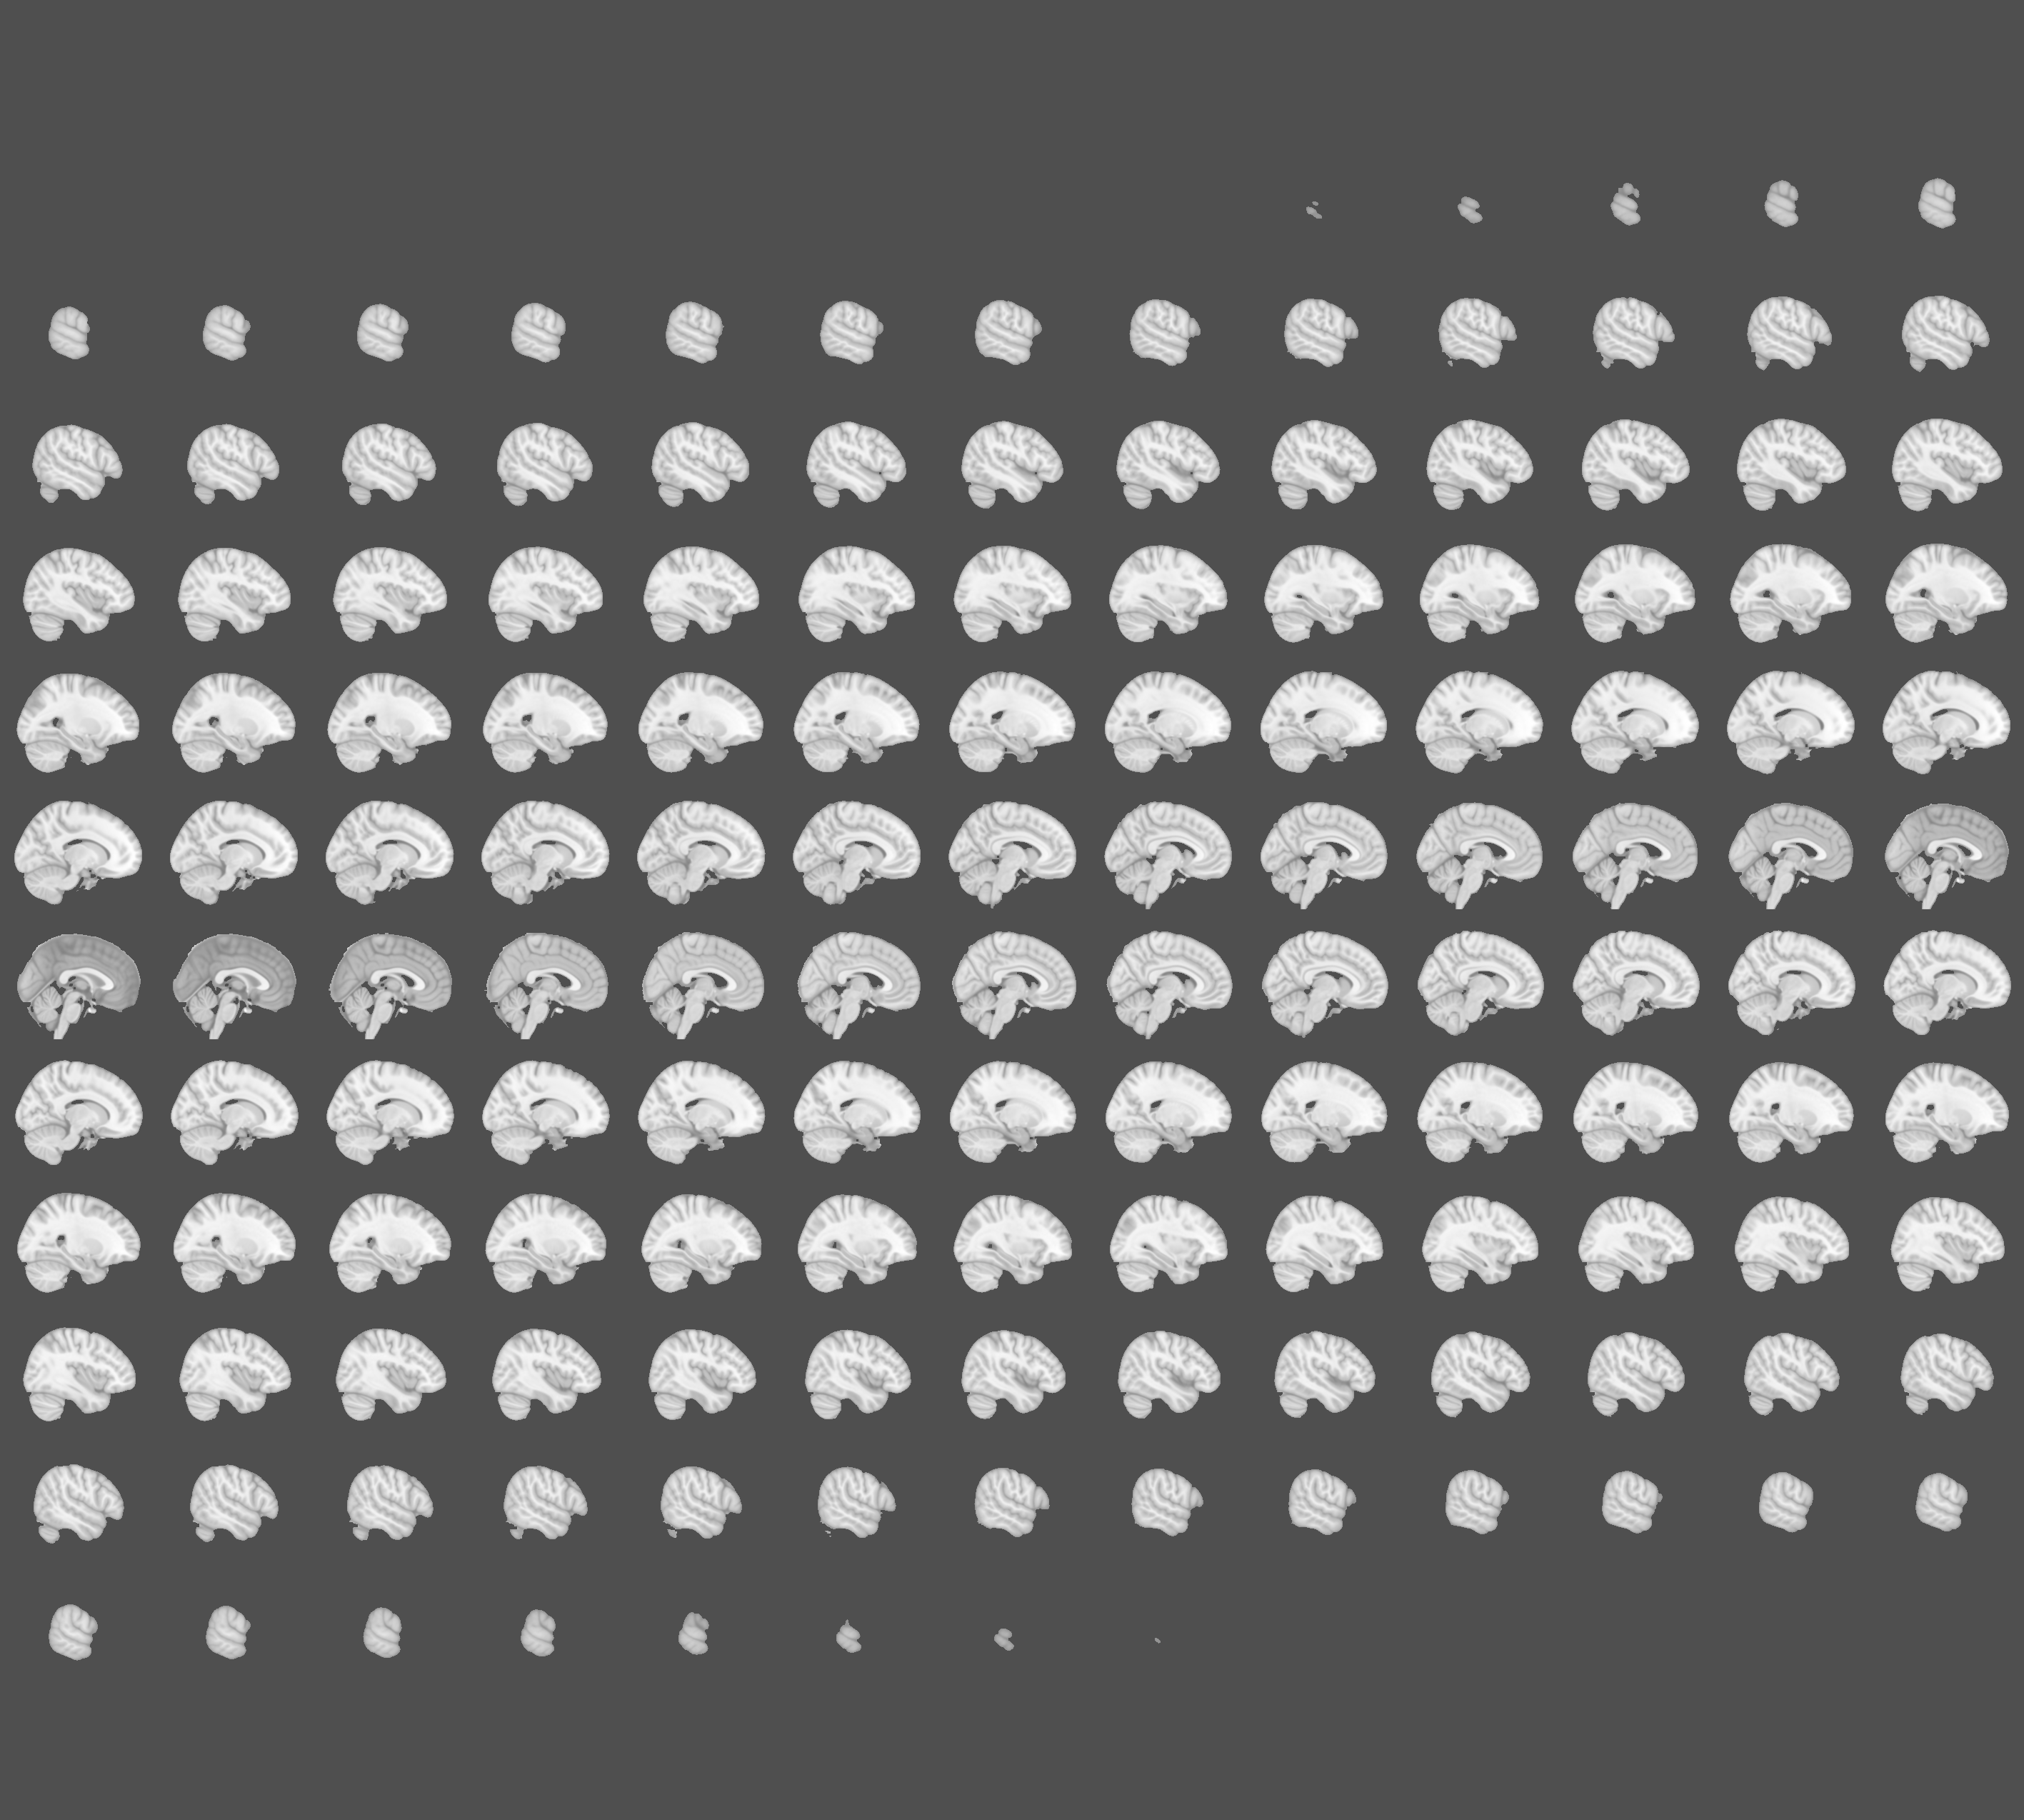
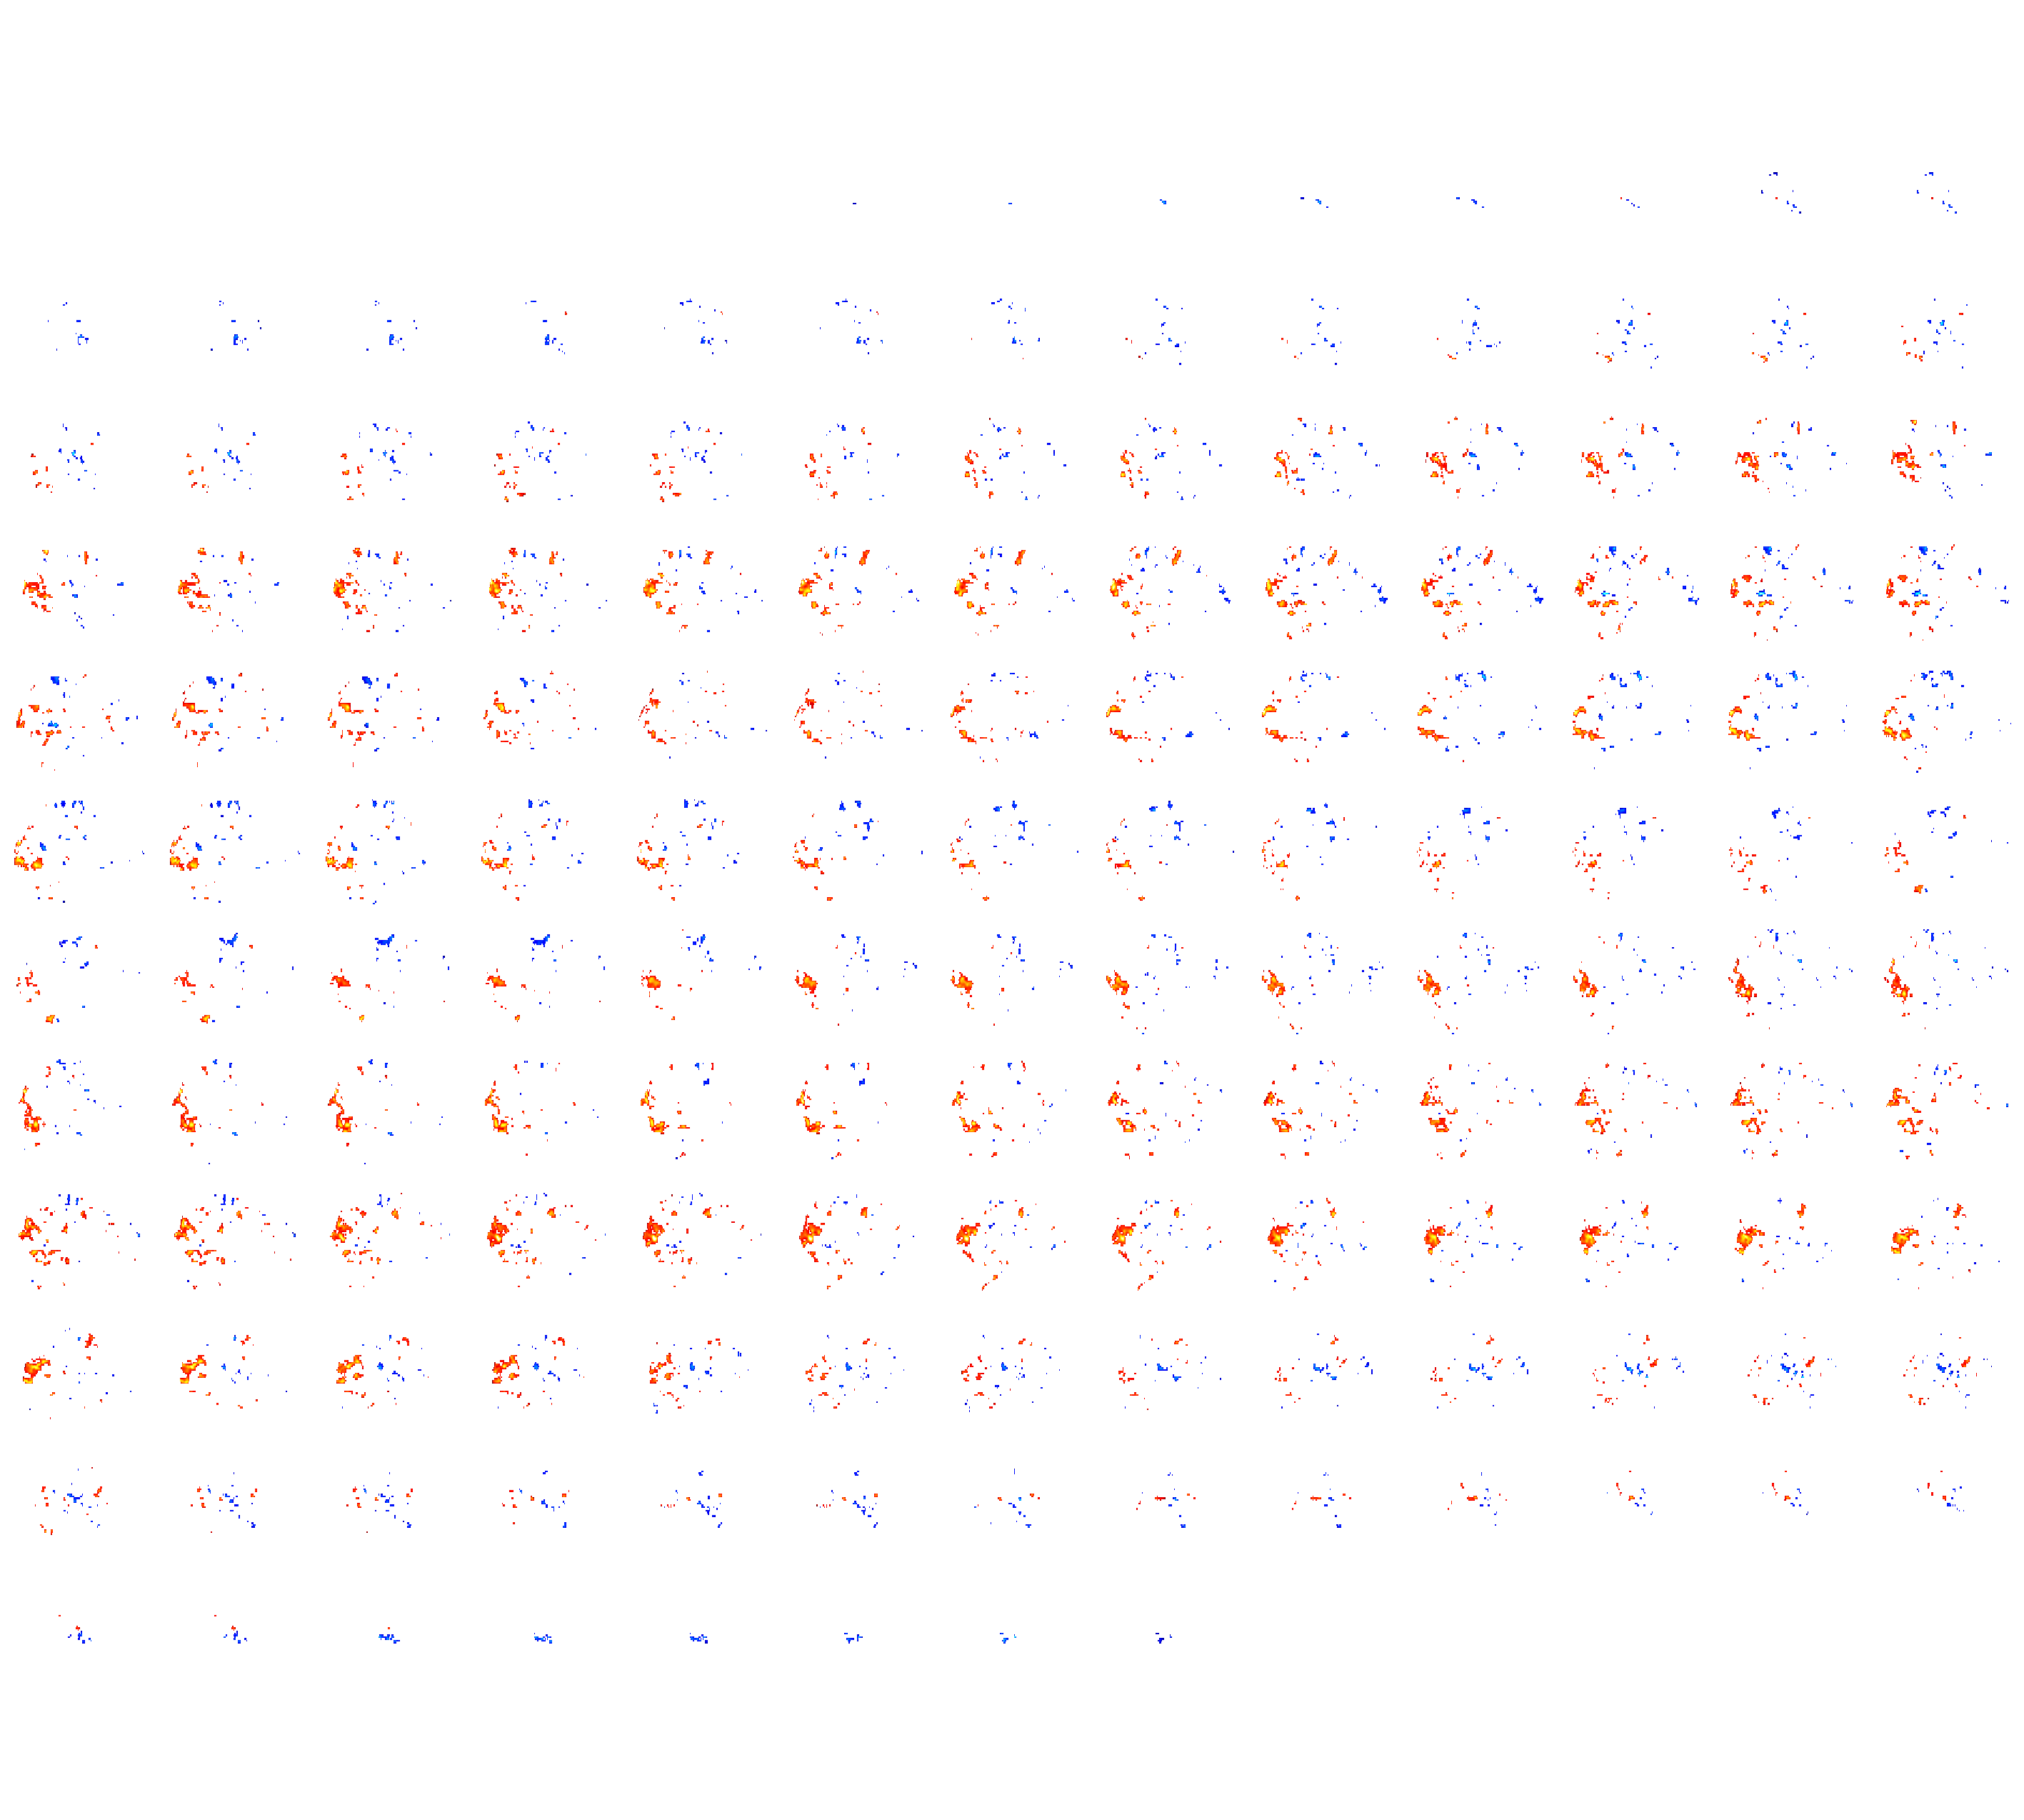

In [44]:
from nilearn import plotting 
from nilearn.image import load_img

subject = 'dspfmri21002'
std_img = '/apps/fsl/6.0.5/data/standard/MNI152_T1_1mm_brain.nii.gz'
contrast = '1'
output_img = load_img(f'/blue/stevenweisberg/share/DSP_fMRI/derivatives/first_level/{subject}/tstats/_contrast_num_{contrast}_sub-{subject}/_flameo0/tstat1.nii.gz')
plotting.view_img(output_img,bg_img=std_img,threshold=4,black_bg=False,cut_coords=(30,-30,-10))